# Classic ML classification techniques

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from collections import Counter
import warnings
import os
import sys

# libs for ml
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, robust_scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
current_file_path = os.getcwd()
project_root =  os.path.dirname(os.path.dirname(current_file_path))
sys.path.append(str(project_root))

# my module with some func
import modules.modules_onehot.pepcode as pepcode
import modules.modules_onehot.constants as constants
from modules.modules_kidera.gpu import GPU

## Set parameters

In [2]:
AA_LIST = pepcode.AA_LIST

latent_dims = 64
batch_size = 400
learning_rate = 1e-4 
use_gpu = constants.USE_GPU
device = GPU(use_gpu)

sns.set_theme(style="darkgrid")
default_color = "xkcd:dark pastel green"

## Load and encode data

In [3]:
# Load data
X_train = pd.read_csv('../../dataset/X_train.csv')
X_test = pd.read_csv('../../dataset/X_test.csv')
y_train = pd.read_csv('../../dataset/y_train.csv')
y_test = pd.read_csv('../../dataset/y_test.csv')


# To lists
X_train_cdr3_list_ori = X_train.cdr3.values
X_train_ep_list_ori = X_train.antigen_epitope.values

X_test_cdr3_list_ori = X_test.cdr3.values
X_test_ep_list_ori = X_test.antigen_epitope.values

#Gap insertion (Train)
X_train_cdr3_list = []
X_train_epitops_list = []
for cdr3, ep in zip(X_train_cdr3_list_ori, X_train_ep_list_ori):
    gap_count_for_cdr3 = 19-len(cdr3) # max_len = 19
    gap_count_for_ep = 20-len(ep) # max_len = 20
    
    X_train_cdr3_list.append(cdr3[0:3]+'-'*gap_count_for_cdr3+cdr3[3:])
    X_train_cdr3_list.append(cdr3[0:4]+'-'*gap_count_for_cdr3+cdr3[4:])
    X_train_cdr3_list.append(cdr3[0:-3]+'-'*gap_count_for_cdr3+cdr3[-3:])
    X_train_cdr3_list.append(cdr3[0:-4]+'-'*gap_count_for_cdr3+cdr3[-4:])
    
    X_train_epitops_list.append(ep[0:3]+'-'*gap_count_for_ep+ep[3:])
    X_train_epitops_list.append(ep[0:4]+'-'*gap_count_for_ep+ep[4:])
    X_train_epitops_list.append(ep[0:-3]+'-'*gap_count_for_ep+ep[-3:])
    X_train_epitops_list.append(ep[0:-4]+'-'*gap_count_for_ep+ep[-4:])

len_cdr3 = len(X_train_cdr3_list[0])
len_ep = len(X_train_epitops_list[0])

#Gap insertion (test)
X_test_cdr3_list = []
X_test_epitops_list = []
for cdr3, ep in zip(X_test_cdr3_list_ori, X_test_ep_list_ori):
    gap_count_for_cdr3 = 19-len(cdr3) # max_len = 19
    gap_count_for_ep = 20-len(ep) # max_len = 20
    
    X_test_cdr3_list.append(cdr3[0:3]+'-'*gap_count_for_cdr3+cdr3[3:])
    X_test_cdr3_list.append(cdr3[0:4]+'-'*gap_count_for_cdr3+cdr3[4:])
    X_test_cdr3_list.append(cdr3[0:-3]+'-'*gap_count_for_cdr3+cdr3[-3:])
    X_test_cdr3_list.append(cdr3[0:-4]+'-'*gap_count_for_cdr3+cdr3[-4:])
    
    X_test_epitops_list.append(ep[0:3]+'-'*gap_count_for_ep+ep[3:])
    X_test_epitops_list.append(ep[0:4]+'-'*gap_count_for_ep+ep[4:])
    X_test_epitops_list.append(ep[0:-3]+'-'*gap_count_for_ep+ep[-3:])
    X_test_epitops_list.append(ep[0:-4]+'-'*gap_count_for_ep+ep[-4:])

#To One-hot (Train)
X_train_cdr3_oh = np.zeros((len(X_train_cdr3_list), len(pepcode.AA_LIST), len_cdr3), dtype = np.float32)
for i in range(len(X_train_cdr3_oh)):
    X_train_cdr3_oh[i] = pepcode.one_hot_code(X_train_cdr3_list[i])

X_train_ep_oh = np.zeros((len(X_train_epitops_list), len(pepcode.AA_LIST), len_ep), dtype = np.float32)
for i in range(len(X_train_ep_oh)):
    X_train_ep_oh[i] = pepcode.one_hot_code(X_train_epitops_list[i])

cdr3_oh_matr_size = X_train_cdr3_oh[0].size
ep_oh_matr_size = X_train_ep_oh[0].size

#To One-hot (Test)
X_test_cdr3_oh = np.zeros((len(X_test_cdr3_list), len(pepcode.AA_LIST), len_cdr3), dtype = np.float32)
for i in range(len(X_test_cdr3_oh)):
    X_test_cdr3_oh[i] = pepcode.one_hot_code(X_test_cdr3_list[i])

X_test_ep_oh = np.zeros((len(X_test_epitops_list), len(pepcode.AA_LIST), len_ep), dtype = np.float32)
for i in range(len(X_test_ep_oh)):
    X_test_ep_oh[i] = pepcode.one_hot_code(X_test_epitops_list[i])

# Prepare cdr3 dataloader (Train)
X_train_cdr3_oh_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_cdr3_oh), torch.tensor(np.ones(X_train_cdr3_oh.shape[0])))
X_train_cdr3_oh_dl = torch.utils.data.DataLoader(X_train_cdr3_oh_dataset, batch_size=batch_size, shuffle=False)

# Prepare ep dataloader (Train)
X_train_ep_oh_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_ep_oh), torch.tensor(np.ones(X_train_ep_oh.shape[0])))
X_train_ep_oh_dl = torch.utils.data.DataLoader(X_train_ep_oh_dataset, batch_size=batch_size, shuffle=False)

# Prepare cdr3 dataloader (test)
X_test_cdr3_oh_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_cdr3_oh), torch.tensor(np.ones(X_test_cdr3_oh.shape[0])))
X_test_cdr3_oh_dl = torch.utils.data.DataLoader(X_test_cdr3_oh_dataset, batch_size=batch_size, shuffle=False)

# Prepare ep dataloader (test)
X_test_ep_oh_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_ep_oh), torch.tensor(np.ones(X_test_ep_oh.shape[0])))
X_test_ep_oh_dl = torch.utils.data.DataLoader(X_test_ep_oh_dataset, batch_size=batch_size, shuffle=False)

### Autoencoder for cdr3

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=cdr3_oh_matr_size, out_features=latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=cdr3_oh_matr_size),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encoding(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoding(self, encoded):
        decoded = self.decoder(encoded)
        return decoded


model_cdr3 = Autoencoder()
model_cdr3 = torch.load('../../models/models_onehot/cdr3_model_final.pth', weights_only=False)
model_cdr3 = model_cdr3.to(device)
loss_function = nn.CrossEntropyLoss()

# Make X_train embeddings
model_cdr3.eval()

output = [] # For hiddens
test_loss_avg, num_batches = 0, 0

for (pep, _) in X_train_cdr3_oh_dl:
    with torch.no_grad():
        pep_o = pep
        pep_o = pep_o.to(device)
        pep = pep.reshape(-1, cdr3_oh_matr_size)
        pep = pep.to(device)
        pep_encod = model_cdr3.encoding(pep)
        pep_recon = model_cdr3(pep)
        pep_recon_rs = pep_recon.reshape(pep_o.shape)
        loss = loss_function(pep_recon_rs, pep_o)
        test_loss_avg += loss.item()
        num_batches += 1
    output.append((pep, pep_encod))
test_loss_avg /= num_batches
print('Average reconstruction error on train: %f' % (test_loss_avg))

X_train_cdr3_embd = np.zeros((len(X_train_cdr3_list), latent_dims), dtype = np.float32)

pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    X_train_cdr3_embd[pointer:pointer + cur_batch_size, :] = output[i][1].reshape((cur_batch_size, latent_dims)).numpy(force=True)
    pointer += cur_batch_size

X_train_cdr3_embd_rs = X_train_cdr3_embd.reshape(len(X_train_cdr3_list_ori), 4*64)

# Make X_test embeddings
output = [] 
test_loss_avg, num_batches = 0, 0

for (pep, _) in X_test_cdr3_oh_dl:
    with torch.no_grad():
        pep_o = pep
        pep_o = pep_o.to(device)
        pep = pep.reshape(-1, cdr3_oh_matr_size)
        pep = pep.to(device)
        pep_encod = model_cdr3.encoding(pep)
        pep_recon = model_cdr3(pep)
        pep_recon_rs = pep_recon.reshape(pep_o.shape)
        loss = loss_function(pep_recon_rs, pep_o)
        test_loss_avg += loss.item()
        num_batches += 1
    output.append((pep, pep_encod))
test_loss_avg /= num_batches
print('Average reconstruction error on test: %f' % (test_loss_avg))

X_test_cdr3_embd = np.zeros((len(X_test_cdr3_list), latent_dims), dtype = np.float32)

pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    X_test_cdr3_embd[pointer:pointer + cur_batch_size, :] = output[i][1].reshape((cur_batch_size, latent_dims)).numpy(force=True)
    pointer += cur_batch_size

X_test_cdr3_embd_rs = X_test_cdr3_embd.reshape(len(X_test_cdr3_list_ori), 4*64)


Average reconstruction error on train: 0.003687
Average reconstruction error on test: 0.004106


### Autoencoder for epitops

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=ep_oh_matr_size, out_features=latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=ep_oh_matr_size),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encoding(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoding(self, encoded):
        decoded = self.decoder(encoded)
        return decoded


model_ep = Autoencoder()
model_ep = torch.load('../../models/models_onehot/epitope_model_final.pth', weights_only=False)
model_ep = model_ep.to(device)
loss_function = nn.CrossEntropyLoss()

# Make X_train epitope embeddings
model_ep.eval()

output = [] # For hiddens
test_loss_avg, num_batches = 0, 0

for (pep, _) in X_train_ep_oh_dl:
    with torch.no_grad():
        pep_o = pep
        pep_o = pep_o.to(device)
        pep = pep.reshape(-1, ep_oh_matr_size)
        pep = pep.to(device)
        pep_encod = model_ep.encoding(pep)
        pep_recon = model_ep(pep)
        pep_recon_rs = pep_recon.reshape(pep_o.shape)
        loss = loss_function(pep_recon_rs, pep_o)
        test_loss_avg += loss.item()
        num_batches += 1
    output.append((pep, pep_encod))
test_loss_avg /= num_batches
print('Average reconstruction error on Train: %f' % (test_loss_avg))


X_train_ep_embd = np.zeros((len(X_train_epitops_list), latent_dims), dtype = np.float32)

pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    X_train_ep_embd[pointer:pointer + cur_batch_size, :] = output[i][1].reshape((cur_batch_size, latent_dims)).numpy(force=True)
    pointer += cur_batch_size

X_train_ep_embd_rs = X_train_ep_embd.reshape(len(X_train_ep_list_ori), 4*64)

# Make X_test epitope embeddings
output = [] # For hiddens
test_loss_avg, num_batches = 0, 0

for (pep, _) in X_test_ep_oh_dl:
    with torch.no_grad():
        pep_o = pep
        pep_o = pep_o.to(device)
        pep = pep.reshape(-1, ep_oh_matr_size)
        pep = pep.to(device)
        pep_encod = model_ep.encoding(pep)
        pep_recon = model_ep(pep)
        pep_recon_rs = pep_recon.reshape(pep_o.shape)
        loss = loss_function(pep_recon_rs, pep_o)
        test_loss_avg += loss.item()
        num_batches += 1
    output.append((pep, pep_encod))
test_loss_avg /= num_batches
print('Average reconstruction error on test: %f' % (test_loss_avg))


X_test_ep_embd = np.zeros((len(X_test_epitops_list), latent_dims), dtype = np.float32)

pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    X_test_ep_embd[pointer:pointer + cur_batch_size, :] = output[i][1].reshape((cur_batch_size, latent_dims)).numpy(force=True)
    pointer += cur_batch_size

X_test_ep_embd_rs = X_test_ep_embd.reshape(len(X_test_ep_list_ori), 4*64)

Average reconstruction error on Train: 0.000412
Average reconstruction error on test: 0.000585


In [6]:
en_train_data = pd.DataFrame(np.concatenate((X_train_cdr3_embd_rs, X_train_ep_embd_rs), axis=1))
en_test_data = pd.DataFrame(np.concatenate((X_test_cdr3_embd_rs, X_test_ep_embd_rs), axis=1))
en_train_data          

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-6.502210,4.985078,0.796359,-0.337377,0.957776,1.281052,2.809539,3.557233,1.002459,2.010046,...,-0.392320,4.304760,-1.559409,0.675484,-2.809920,-1.548927,-0.539190,2.054389,1.632064,-3.387748
1,-3.420376,1.919051,2.890433,2.074486,4.829968,-1.550960,1.245930,4.510501,0.597796,-0.462118,...,-2.086086,-3.805146,-0.077178,-2.242806,-1.692053,1.075092,3.617678,-1.766546,-1.741641,1.721305
2,-10.287714,2.415894,1.509509,-0.599912,-1.614881,0.889358,4.093733,2.645226,4.296120,0.677016,...,1.218052,-0.409063,-0.172544,1.509683,-6.396903,-4.479070,5.174968,0.107380,5.902940,0.360363
3,-3.265219,5.067368,-1.944394,1.470813,-1.234721,3.627056,2.296020,-0.053287,1.989043,4.664782,...,-2.185002,-0.657694,-2.513651,3.120286,-1.485379,1.682453,2.843132,-1.658021,2.712762,-3.118139
4,-3.959286,2.448424,3.429009,3.168597,0.173106,-0.072676,3.318324,1.353975,-0.232162,5.476536,...,-0.676406,-1.456790,-6.343202,5.089431,-8.052140,-2.356643,-2.259907,0.667936,4.430921,-0.480201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43666,-1.607435,1.682030,-4.624017,0.715186,-0.305160,-0.391930,0.451917,2.394166,-0.173165,3.184960,...,2.647845,0.429482,-0.046764,5.609344,-6.432147,-2.093629,3.111864,0.985709,1.253531,-2.356506
43667,0.336176,4.858846,-2.153716,-6.397249,0.009275,-1.723733,-0.463869,5.707293,2.332285,-0.015583,...,-2.185002,-0.657694,-2.513651,3.120286,-1.485379,1.682453,2.843132,-1.658021,2.712762,-3.118139
43668,-3.746172,1.341795,1.713740,3.235488,-0.331747,0.790664,2.647597,1.939874,-1.132390,3.847513,...,-2.185002,-0.657694,-2.513651,3.120286,-1.485379,1.682453,2.843132,-1.658021,2.712762,-3.118139
43669,1.906123,8.005573,5.497252,-0.647267,0.550672,-2.887609,-2.377649,3.540972,3.202432,1.103681,...,-0.807140,-1.759477,-2.532099,-0.594497,-0.230283,1.040122,-0.669755,2.375261,-1.107657,7.112207


## EDA

### Heatmaps

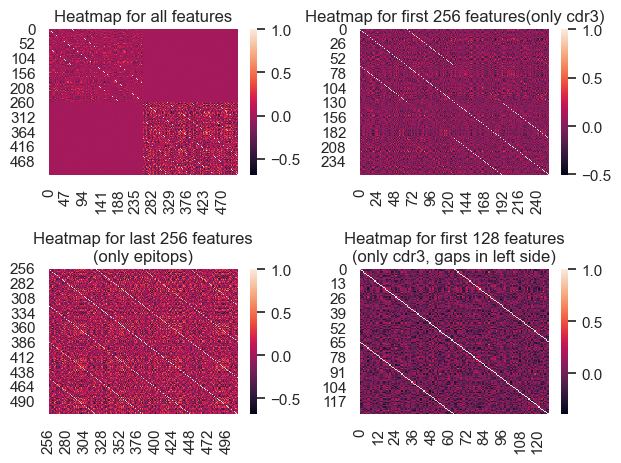

Number of columns with hight(>0.9) correlation 211


In [7]:
fig, axs = plt.subplots(2, 2)

# Full data heatmap
corr_f = en_train_data.corr()
sns.heatmap(corr_f, ax=axs[0, 0])
axs[0, 0].set(title='Heatmap for all features')


#First 256 features heatmap
corr_r = en_train_data.iloc[:,0:256].corr()
sns.heatmap(corr_r, ax=axs[0, 1])
axs[0, 1].set(title='Heatmap for first 256 features(only cdr3)')

#Last 256 features heatmap
corr_r = en_train_data.iloc[:,256:].corr()
sns.heatmap(corr_r, ax=axs[1, 0])
axs[1, 0].set(title='Heatmap for last 256 features\n(only epitops)')

#First 128 features heatmap
corr_r = en_train_data.iloc[:,0:128].corr()
sns.heatmap(corr_r, ax=axs[1, 1])
axs[1, 1].set(title='Heatmap for first 128 features\n(only cdr3, gaps in left side)')
plt.tight_layout()
plt.show()

upper_tri = corr_f.where(np.triu(np.ones(corr_f.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.9)]
print(f'Number of columns with hight(>0.9) correlation {len(to_drop)}')
# !!! You can drop columns with hight correlation
# en_train_data = en_train_data.drop(columns = to_drop)
# en_test_data = en_test_data.drop(columns = to_drop)

### Scaling

In [8]:
en_train_data_sc = en_train_data.copy()
en_train_data_sc = robust_scale(en_train_data, axis = 1)

en_test_data_sc = en_test_data.copy()
en_test_data_sc = robust_scale(en_test_data, axis = 1)

### PCA

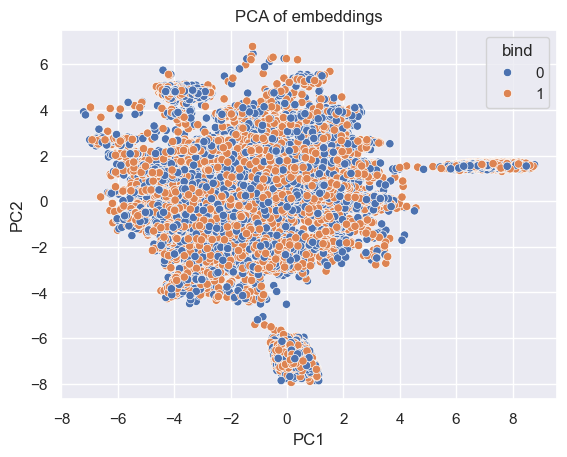

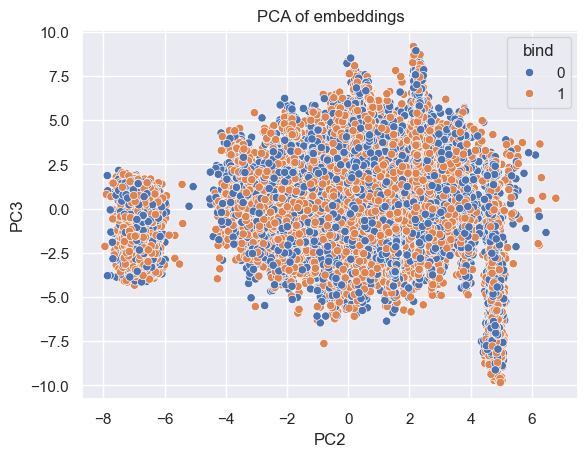

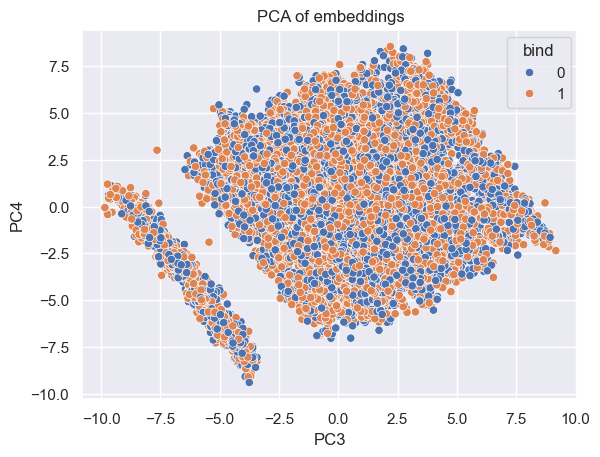

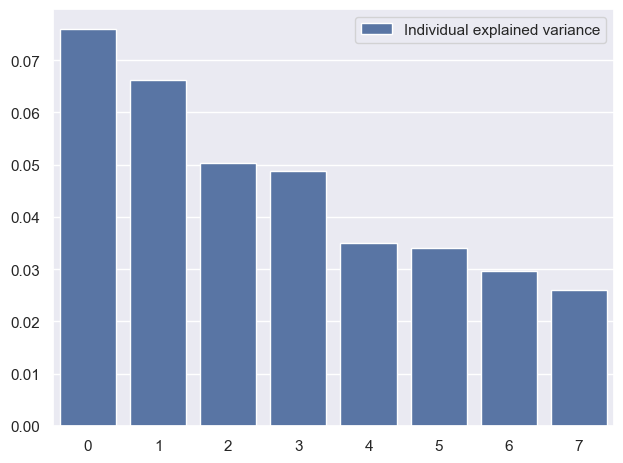

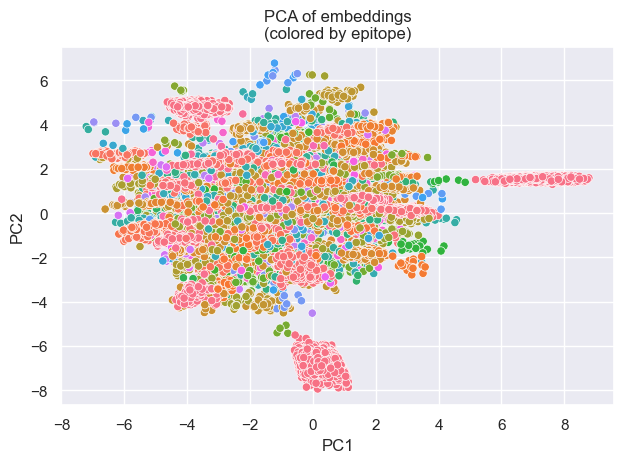

In [9]:
pca = PCA()
pca_data = pca.fit_transform(en_train_data_sc)

pca_data_plot = pd.DataFrame({'PC1': pca_data[:, 0],
                            'PC2': pca_data[:, 1],
                            'PC3': pca_data[:, 2],
                            'PC4': pca_data[:, 3],
                            'PC5': pca_data[:, 4],
                            'PC6': pca_data[:, 5],
                            'PC7': pca_data[:, 6],
                            'PC8': pca_data[:, 7],
                            'PC9': pca_data[:, 8],
                            'bind': y_train.bind,
                            'epitope': X_train.antigen_epitope
                             })
#plot individual PC
for i in range(1, 4):
    sns.scatterplot(pca_data_plot, x = f'PC{i}', y = f'PC{i+1}', hue = 'bind')
    plt.title(f'PCA of embeddings')
    plt.show()

#plot explained variance
explained_variance_ratio = pca.explained_variance_ratio_
x = range(8)
sns.barplot(x = x, y = explained_variance_ratio[:8,], label = 'Individual explained variance')
plt.tight_layout()
plt.show()

#plot PC1 and PC2 hue by epitope
sns.scatterplot(pca_data_plot, x = f'PC{1}', y = f'PC{2}', hue = 'epitope', legend=False)
plt.title(f'PCA of embeddings\n(colored by epitope)')
plt.tight_layout()
plt.show()

### TSNE

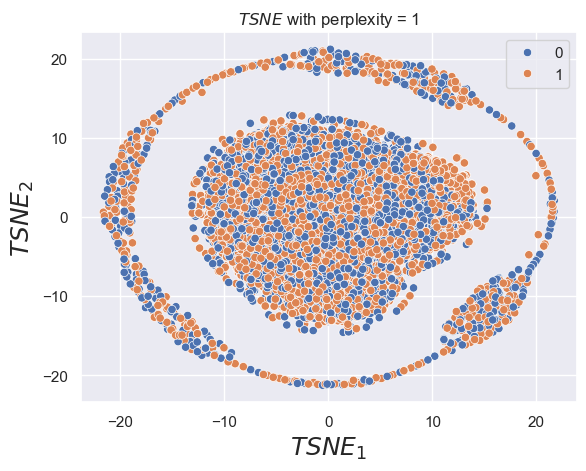

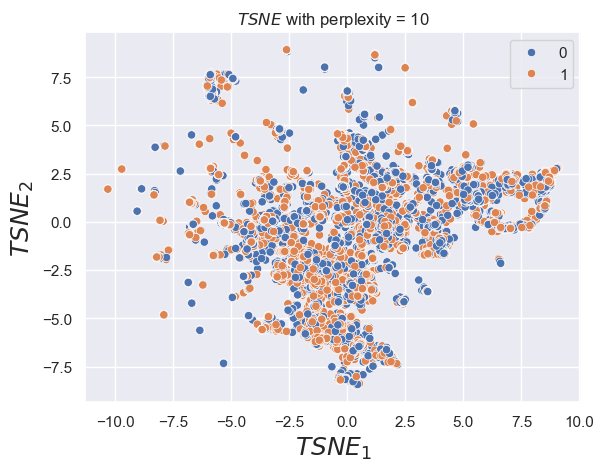

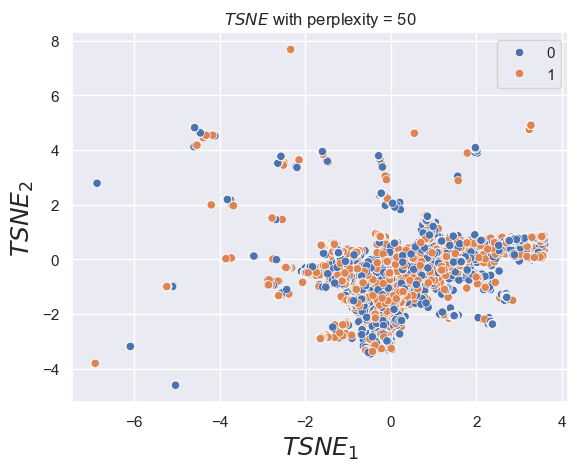

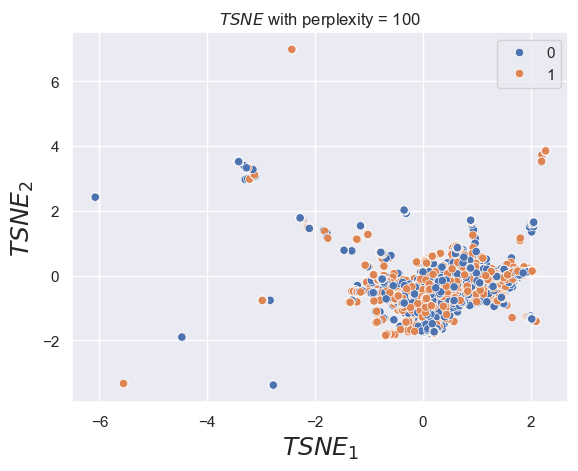

In [10]:
perplexity_list = [1, 10, 50, 100]
for j, i in enumerate(perplexity_list):
    tsne = TSNE(n_components=2, n_jobs=-1, init=pca_data[:, :2],
                    n_iter=250, perplexity=i)
    tsne_data = tsne.fit_transform(pca_data)
    plt.figure(j)
    sns.scatterplot(x=tsne_data [:, 0],
                    y=tsne_data [:, 1],
                    hue=y_train.values.reshape(-1))
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    plt.title(f'$TSNE$ with perplexity = {i}')
    plt.show

### Try classic ML methods

In [11]:
def get_model(model):
    '''
    Get the model from six state-of-the-art machine learning models.
    '''
    if model=='svm':
        from sklearn.svm import SVC
        names = ["Linear SVM"]
        classifiers = [
        SVC()
        ]
    elif model=='ab':
        from sklearn.ensemble import AdaBoostClassifier
        names = ["AdaBoost"]
        classifiers = [
        AdaBoostClassifier()
        ]
    elif model=='knn':
        from sklearn.neighbors import KNeighborsClassifier
        names = ["K-Nearest Neighbors"]
        classifiers = [
        KNeighborsClassifier()
        ]
    elif model=='dt':
        from sklearn.tree import DecisionTreeClassifier
        names = ["Decision Tree"]
        classifiers = [
        DecisionTreeClassifier()
        ]
    elif model=='nb':
        from sklearn.naive_bayes import GaussianNB
        names = ["Naive Bayes"]
        classifiers = [
         GaussianNB()
        ]
    elif model=='rfc':
        from sklearn.ensemble import RandomForestClassifier
        names = ["Random Forest"]
        classifiers = [
        RandomForestClassifier()
        ]
    elif model=='xgboost':
        from xgboost import XGBClassifier
        names = ["XGBoost"]
        classifiers = [
        XGBClassifier()
        ]
    elif model=='mlp':
        from sklearn.neural_network import MLPClassifier
        names = ["MLPClassifier"]
        classifiers = [
        MLPClassifier()
        ]
    else:
        raise RuntimeError('Unknown classifier')

    return names, classifiers

In [12]:
parameters = {
              'svm': {'model__C': (0.1, 1, 10), 'model__kernel': (['rbf']), 'model__probability': [True]},
              'ab': {'model__n_estimators': (10, 50, 100)},
              'knn': {'model__n_neighbors': (1, 2, 5, 7, 10, 20, 50), 'model__weights': ('uniform', 'distance')},
              'dt': {'model__max_depth': (5, 10, 20, 50), 'model__min_samples_split': (2, 10, 50, 100)},
              'nb': {},
              'rfc': {'model__max_depth': (2, 7, 20, 30), 'model__n_estimators': (50, 200, 400, 700, 1000)},
              'xgboost': {'model__max_depth': (5, 10, 30), 'model__grow_policy': ('depthwise', 'lossguide')},
              'mlp': {'model__hidden_layer_sizes': (100, 200, 800), 'model__activation': ('logistic','relu'), 'model__alpha': (0, 0.0001)}
            }

In [13]:
train_df = pd.DataFrame(data = pca_data)
test_df = pd.DataFrame(data = pca.transform(en_test_data_sc))

In [14]:
exp_n = 1
f_name = f'../../results/results_onehot/{str(date.today())}_experiment_{exp_n}.txt'

In [15]:
descr = f'Description:\nCompare classic ML models on full data.\n'

**Warning: next cell very time consumptive(~12 hours)**

In [ ]:
best_clfs_encode = {}
with open(f_name, mode='w') as f:
    f.write(descr)
    for name, param in parameters.items():
        f.write(f'For model:{get_model(name)[1][0]}, parameters: {str(param)}\n')
    print('Start working...')
    for name, param in parameters.items():
        model = get_model(name)[1][0]
        model_name = get_model(name)[1][0]
        steps = [('model', model)]
        pipeline = Pipeline(steps=steps)
        print(f'Optimizing {model_name}...')
        clf = GridSearchCV(pipeline, param, scoring='roc_auc',  n_jobs=-1)
        clf.fit(train_df.values, y_train.bind)
        f.write(f'Best params for {model_name}:{clf.best_params_}\n')
        pipe = clf.best_estimator_['model']
        log_string = f'Test ROC AUC for the best {model_name} model {round(roc_auc_score(y_test.bind, pipe.predict_proba(test_df.values)[:,1]), 4)}'
        f.write(log_string)
        f.write('\n')
        print(log_string)
        print(f'\nCalculation done for {model_name}!\n')
        best_clfs_encode[name] = clf.best_estimator_

In [ ]:
from sklearn.svm import SVC
clf = SVC(C=1, kernel='rbf', probability=True)
steps = [('model', clf)]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_df.values, y_train.bind)

In [ ]:
predicted = pipeline.predict_proba(test_df)

In [ ]:
roc_auc = roc_auc_score(y_test.bind, predicted[:,1])

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.bind, predicted[:,1])
f = plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color = default_color)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate',  size=20)
plt.ylabel('True Positive Rate',  size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('ROC curve for one-hot best model', size=20)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()